In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
# from scipy import signal
# from scipy.stats import entropy
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')

## Генерация данных

In [32]:
# Мультипликативность через произведение

# def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = True):
#     if random_seed:
#         np.random.seed(random_seed)
        
#     signal = np.cos(2*np.pi/24 * np.arange(0, ts_length) + (np.pi/2))
#     noise = np.random.normal(0,0.1,ts_length)
#     signal = signal+noise

#     change_point = np.random.choice(np.arange(points_to_skip,ts_length),1)[0]
#     change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
#     change_point_value = np.random.normal(0.5,0.1,1)*np.random.choice([-1,1],1,)[0]
#     if is_multiplicative:
#         change_point_mult_value = 1+change_point_value
#     else:
#         change_point_mult_value = 1
    
#     if change_point:
#         signal[change_point:] = (signal[change_point:]+change_point_value) * change_point_mult_value
#     else:
#         change_point_value = None
#     return([signal, change_point, change_point_value])

In [3]:
# Мультипликативность через экспоненту

def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = True):
    if random_seed:
        np.random.seed(random_seed)
        
    signal = np.cos(2*np.pi/24 * np.arange(0, ts_length) + (np.pi/2))
    noise = np.random.normal(0,1,ts_length)
    signal = signal+noise

    change_point = np.random.choice(np.arange(points_to_skip,ts_length-points_to_skip),1)[0]
    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
    change_point_value = np.random.normal(0,3,1)*np.random.choice([-1,1],1,)[0]
    
    if change_point:
        signal[change_point:] = signal[change_point:]+change_point_value
        if is_multiplicative:
            signal = np.exp(signal)
    else:
        change_point_value = None
    return([signal, change_point, change_point_value])

Пример ряда без разладки и без мультипликативности

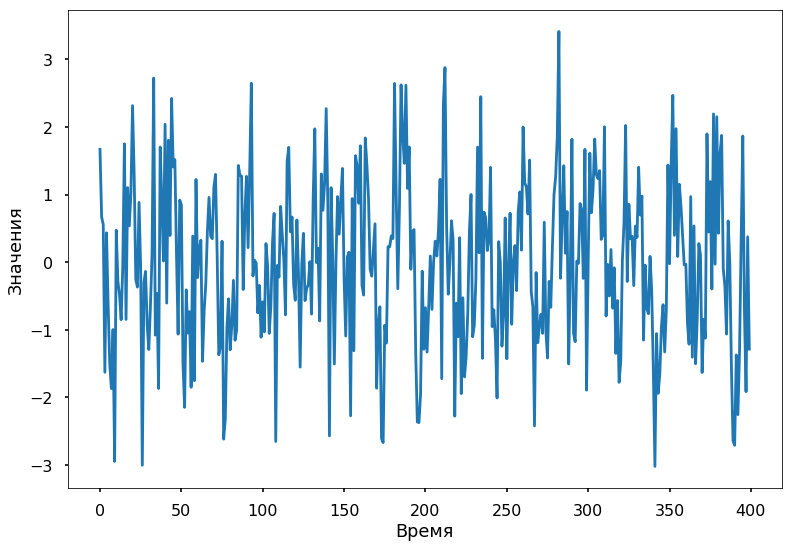

In [17]:
generated = data_generator(cp_prob = 0, is_multiplicative = False, random_seed=102)
plt.plot(generated[0])
plt.ylabel('Значения')
plt.xlabel('Время')
plt.savefig('./fig/data_modeling_example_1.png')
plt.show()

Пример ряда с разладкой, но без мультипликативности

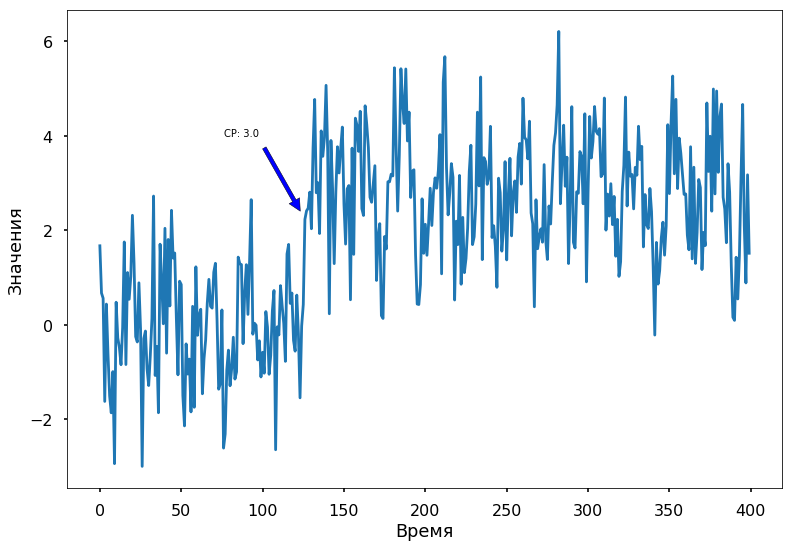

In [24]:
generated = data_generator(cp_prob = 1, is_multiplicative = False, random_seed=102)
plt.plot(generated[0])
plt.ylabel('Значения')
plt.xlabel('Время')
plt.annotate('CP: {}'.format(round(generated[2][0])), xy=(generated[1], generated[0][generated[1]]), xytext=(generated[1]-50, 4), arrowprops=dict(facecolor='blue', shrink=0.1))
plt.savefig('./fig/data_modeling_example_2.png')
plt.show()

Пример ряда с разладкой и с мультипликативностью

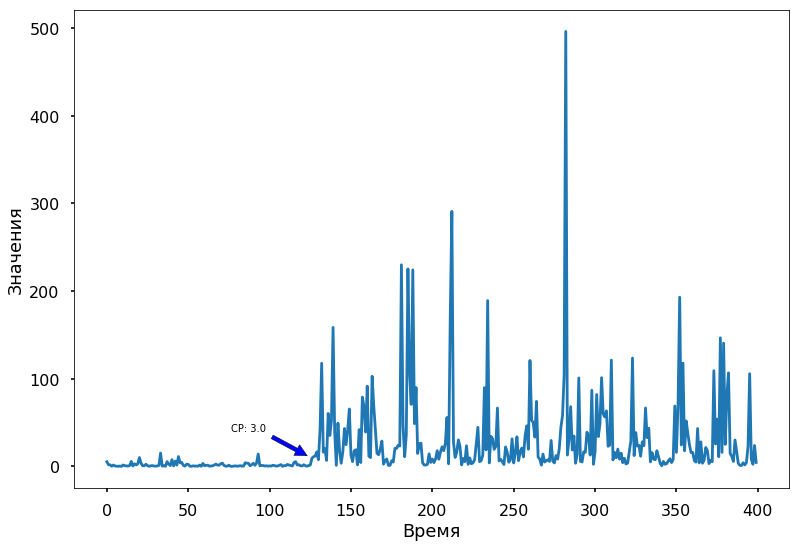

In [30]:
generated = data_generator(cp_prob = 1, is_multiplicative = True, random_seed=102)
plt.plot(generated[0])
plt.ylabel('Значения')
plt.xlabel('Время')
plt.annotate('CP: {}'.format(round(generated[2][0])), xy=(generated[1], generated[0][generated[1]]), xytext=(generated[1]-50, 40), arrowprops=dict(facecolor='blue', shrink=0.1))
plt.savefig('./fig/data_modeling_example_3.png')
plt.show()

## Методы обнаружения разладки

In [99]:
# Старый медленный способ
# def approximation_mean(time_series, window, threshold=None, mode = 0):
# #     time_series = n p.array(time_series)
#     if window%2 != 0:
#         window += 1
#     result = [np.nan]*(window-1)
#     norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)
#     for i in range(len(time_series) - window + 1):
#         all_ts = time_series[i:i+window]
#         left_ts = time_series[i:int(i+window/2)]
#         right_ts = time_series[int(i+window/2):i+window]
        
#         all_ts_cost = np.sum((all_ts - np.mean(all_ts))**2)
#         left_ts_cost = np.sum((left_ts - np.mean(left_ts))**2)
#         right_ts_cost = np.sum((right_ts - np.mean(right_ts))**2)
        
#         result.append((all_ts_cost - left_ts_cost - right_ts_cost)/norm)
        
#         if mode == 1:
#             if max(result) >= threshold:
#                 break
        
#     return(result)

In [34]:
def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided

In [35]:
def approximation_mean(time_series, window, threshold=None):
#     time_series = n p.array(time_series)
    
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)
    
    all_ts_mean = np.convolve(time_series, np.ones((window,))/window, mode='valid')
    all_ts_slides = sliding_window(time_series, window)
    all_ts_cost = np.sum((all_ts_slides - all_ts_mean[:,None])**2,axis=1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    left_ts_cost = np.sum((left_right_ts_slides[:-half_window,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[half_window:,None])**2,axis=1)
    
    
    result.extend(list((all_ts_cost - left_ts_cost - right_ts_cost)/norm))
        
    return(result)

In [36]:
def cp_detection(cost_values, threshold):
    temp_list = [cost_value > threshold for cost_value in cost_values]
    if np.sum(temp_list) > 0:
        cp_index = [cost_value > threshold for cost_value in cost_values].index(True)
    else:
        cp_index = None
    return(cp_index)    

Проверка, что быстрый метод работает корректно

In [15]:
# [round(x,10) for x in approximation_mean(generated[0], 48) if not np.isnan(x)] == [round(x,10) for x in approximation_mean_fast(generated[0], 48) if not np.isnan(x)]

## Оценка качества метода

In [9]:
# def cp_quality(actual, predicted, max_delay = 24):
#     df = pd.DataFrame({'actual':actual, 'predicted':predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
#     df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['predicted'] >= df['actual']), ['actual','predicted']]
#     delay = list(df_temp['predicted'] - df_temp['actual'])
#     df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['predicted'] >= df['actual']), 'delay'] = delay
    
#     df.loc[df['actual'] >= 0, 'actual_binary'] = 1
# #     df.loc[(df['predicted'] >= 0), 'predicted_binary'] = 1
#     df.loc[
#         (df['predicted'] >= 0) & 
#         (((df['predicted'] >= df['actual'])  & 
#               (df['delay'] <= 24)) | 
#         (pd.isna(df['actual']))),
#         'predicted_binary'
#     ] = 1
#     df[['actual_binary','predicted_binary']] = df[['actual_binary','predicted_binary']].fillna(0)
#     conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'])
    
#     return(conf_m, delay) 

In [37]:
def cp_quality(actual, predicted, max_delay = 49):
    df = pd.DataFrame({'actual':actual, 'predicted':predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
    df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
    delay = list(df_temp['predicted'] - df_temp['actual'])
    df.loc[(pd.isna(df['actual']) == False) & 
           (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    df.loc[pd.isna(df['predicted']) == False, 'predicted_binary'] = 1
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['delay'] < 0), 'actual_binary'] = 0
    df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['delay'] > max_delay), 'actual_binary'] = 0
#     df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == True), 'actual_binary'] = 1
    df['actual_binary'] = df['actual_binary'].fillna(1)
    
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
    return(conf_m, delay) 

### Применим для 1 000 рядов с фиксированным порогом и посмотрим на распределение задержек

In [ ]:
# %%time
# act, pred = [], []
# for i in range(1000):    
#     while breaker:
#         generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
#         cp_1 = approximation_mean(generated[0], 48)
#         cp_2 = cp_detection(cp_1, 0.15)
#         pred.append(cp_2)
#         act.append(generated[1])
    
    
#     generated_part = generated[0]
#     generated_part = generated_part[cp_2:]
#     cp_1 = approximation_mean(generated[0], 48)
#     cp_2 = cp_detection(cp_1, 0.15)
#     pred.append(cp_2)
#     act.append(generated[1])
    
    
# cp_result = cp_quality(act, pred, 24)

In [38]:
def cp_detection_modeling(iterations = 1000, max_delay = 49, _window = 48, _cp_prob = 0.8, _is_multiplicative = True, _threshold = 0.15):
    act, pred = [], []
    for i in range(iterations):
        act_temp, pred_temp = [], []
        generated = data_generator(cp_prob = _cp_prob, is_multiplicative = _is_multiplicative)
        generated_part = generated[0]
        breaker, counter = True, 0
        while breaker:
            if counter == 0:
                cp_1 = approximation_mean(generated[0], _window)
                cp_2 = cp_detection(cp_1, _threshold)
                pred_temp.append(cp_2)
                act_temp.append(generated[1])
                if cp_2 == None:
                    breaker = False
                else:
                    generated_part = generated[0][(cp_2+1):]
                    cumulative_cp_2 = cp_2
                counter += 1
            else:
                cp_1 = approximation_mean(generated_part, _window)
                cp_2 = cp_detection(cp_1, _threshold)
                if cp_2 == None:
                    breaker = False
                else:            
                    cumulative_cp_2 += cp_2
                    cp_2 = cumulative_cp_2 + 1
                    pred_temp.append(cp_2)
                    act_temp.append(generated[1])
                    generated_part = generated[0][(cp_2+1):]
                counter += 1

            if len(generated_part) < _window:
                breaker = False
                
        change_point_found = len([x for x in pred_temp if 
                                  (x != None and 
                                  generated[1] != None and 
                                  x <= generated[1]+max_delay and 
                                  x >= generated[1]) or 
                                  x == None or 
                                  generated[1] == None]) # it's better to move this part into cp_quality function
        if change_point_found == 0: # to count cases w/o detection
            pred_temp.append(None)
            act_temp.append(generated[1])
        act.extend(act_temp)
        pred.extend(pred_temp)
    return([act, pred])

In [ ]:
# debug tests

In [31]:
# act, pred = [], []
# for i in range(1):
#     act_temp, pred_temp = [], []
#     generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
#     generated_part = generated[0]
#     breaker, counter = True, 0
#     while breaker:
#         if counter == 0:
#             cp_1 = approximation_mean(generated[0], 48)
#             cp_2 = cp_detection(cp_1, 0.03)
#             print('cp_2 1 {}'.format(cp_2))
#             pred_temp.append(cp_2)
#             act_temp.append(generated[1])
#             if cp_2 == None:
#                 breaker = False
#             else:
#                 generated_part = generated[0][(cp_2+1):]
#                 cumulative_cp_2 = cp_2
#                 print('cumulative_cp_2 1 {}'.format(cumulative_cp_2))
#             counter += 1
#         else:
#             cp_1 = approximation_mean(generated_part, 48)
#             cp_2 = cp_detection(cp_1, 0.03)
#             print('cp_2 2 {}'.format(cp_2))
#             if cp_2 == None:
#                 breaker = False
#             else:            
#                 cumulative_cp_2 += cp_2
#                 print('cumulative_cp_2 2 {}'.format(cumulative_cp_2))
#                 cp_2 = cumulative_cp_2 + 1
#                 print('cp_2 3 {}'.format(cp_2))
#                 pred_temp.append(cp_2)
#                 act_temp.append(generated[1])
#                 generated_part = generated[0][(cp_2+1):]
#             counter += 1

#         if len(generated_part) < 48:
#             breaker = False

#     change_point_found = len([x for x in pred_temp if 
#                               (x != None and 
#                               generated[1] != None and 
#                               x <= generated[1]+49 and 
#                               x >= generated[1]) or 
#                               x == None or 
#                               generated[1] == None]) # it's better to move this part into cp_quality function
#     if change_point_found == 0: # to count cases w/o detection
#         pred_temp.append(None)
#         act_temp.append(generated[1])
#     act.extend(act_temp)
#     pred.extend(pred_temp)
    
# print(act, '\n', pred, '\n', cp_quality(act,pred))

[[212 266]
 [444 342]]


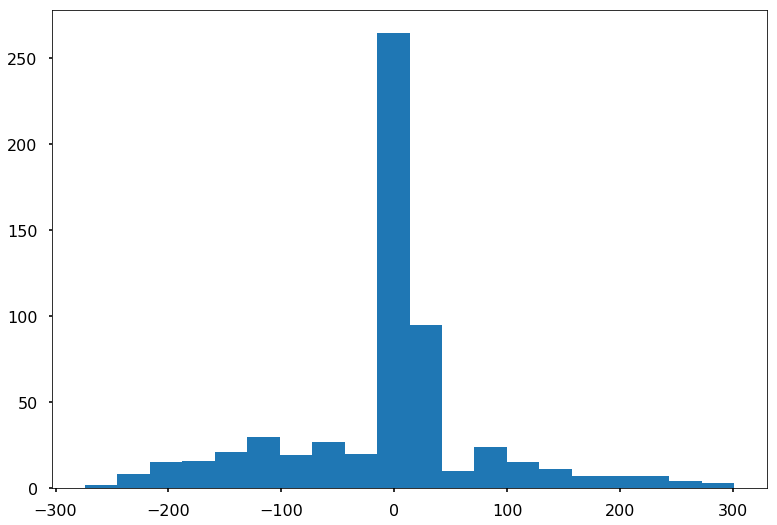

Wall time: 1.67 s


In [42]:
%%time
actual, predicted= cp_detection_modeling(iterations = 1000, _threshold = 0.25)
    
cp_result = cp_quality(actual, predicted, 48)
print(cp_result[0])

plt.hist(cp_result[1], bins = 20)
plt.show()

### Пример одного из сгенерированных рядов

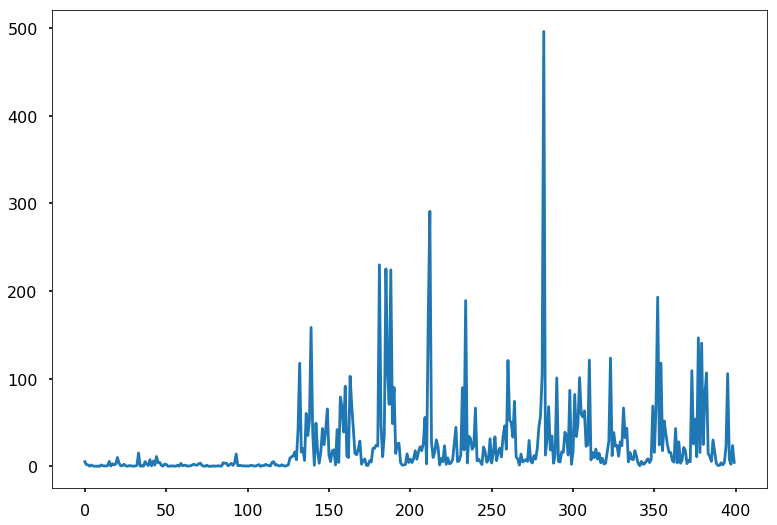

In [43]:
plt.plot(generated[0])
plt.show()

### Функция разладки для этого ряда

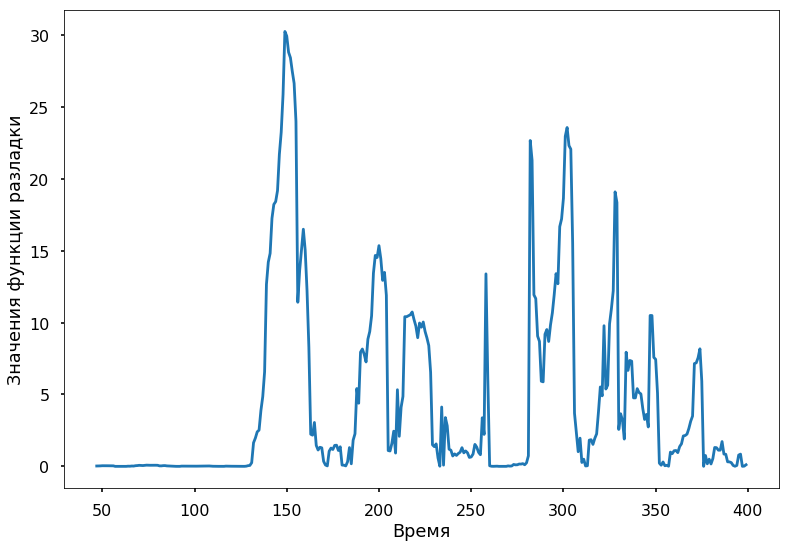

In [46]:
plt.plot(approximation_mean(generated[0], window=48, threshold=None))
plt.ylabel('Значения функции разладки')
plt.xlabel('Время')
plt.savefig('./fig/approximation_mean_1.png')
plt.show()

In [73]:
# %%time
# # df_cp = pd.DataFrame({'actual': None, 'predicted': None, 'threshold': None}, index = [])
# threshold_list = [x/100 for x in range(100)]
# act_temp, pred_temp, tr_temp = [], [], []
# for i in range(1000): 
#     generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
#     cp_1 = approximation_mean(generated[0], 48)
#     for tr in threshold_list:
#         cp_2 = cp_detection(cp_1, tr)
#         act_temp.append(generated[1])
#         pred_temp.append(cp_2)
#         tr_temp.append(tr)
# #         df_cp = df_cp.append({'actual': generated[1], 'predicted': cp_2, 'threshold': tr}, ignore_index=True)
     
# df_cp = pd.DataFrame({'actual': act_temp, 'predicted': pred_temp, 'threshold': tr_temp})

Wall time: 25 s


Заметка: здесь реализовано моделирование новых 1000 рядов для каждого значения порога. Вроде бы ничем не отличается от того, чтобы сначала смоделировать 1000 рядов и для них считать качество метода для разных порогов. Но есть сомнение, что действительно ничем не отличается.

In [101]:
%%time
threshold_list = [x/100 for x in range(100)]
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []

for tr in threshold_list:
    actual_temp, predicted_temp = cp_detection_modeling(iterations = 1000, 
                                              _window = 48,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              _threshold = tr)
    actual.extend(actual_temp)
    predicted.extend(predicted_temp)
    thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

Wall time: 2min 12s


In [102]:
df_cp.shape

(135714, 3)

In [103]:
precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
        
    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
        
    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    
    
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])

unspecificity = [1-x for x in specificity]

In [21]:
temp = cp_quality(df_cp.loc[df_cp['threshold'] == 0.03, 'actual'], 
                     df_cp.loc[df_cp['threshold'] == 0.03, 'predicted']
                          )[0]

print(temp)
print('Recall: {} \n FPR: {}'.format(temp[1,1]/sum(temp[1,:]),temp[0,1]/sum(temp[0,:]) ))

[[   0 4334]
 [  82  768]]
Recall: 0.9035294117647059 
 FPR: 1.0


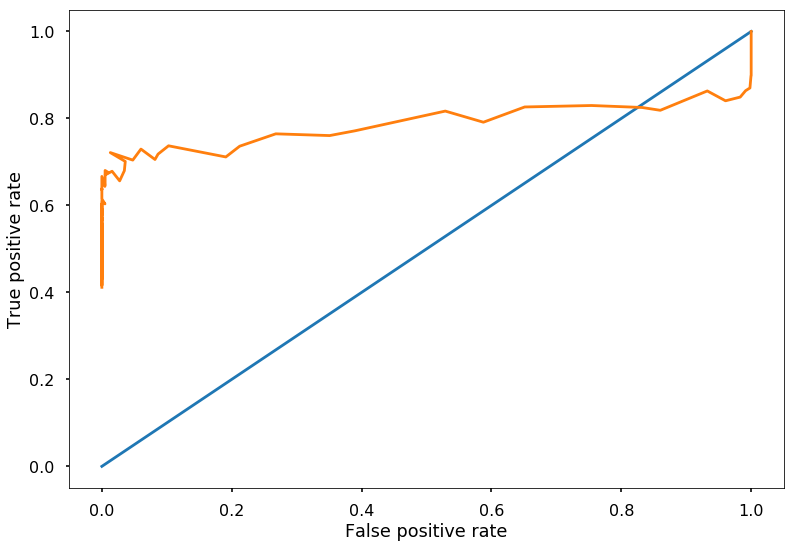

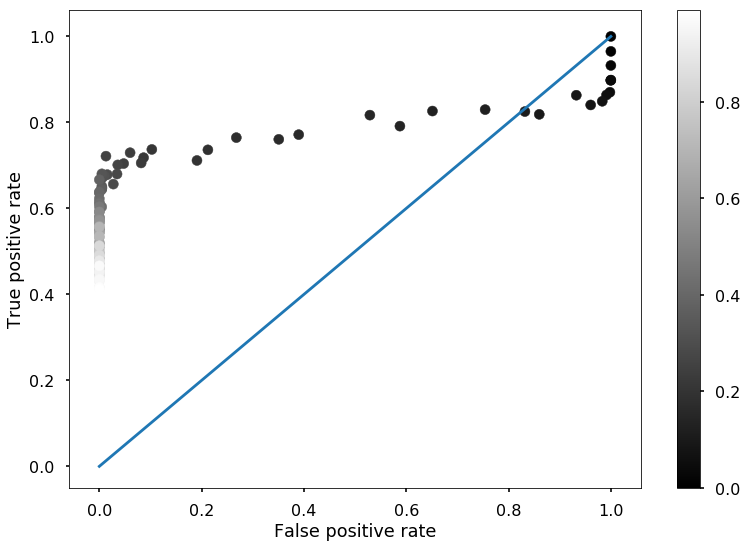

In [104]:
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity, recall)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

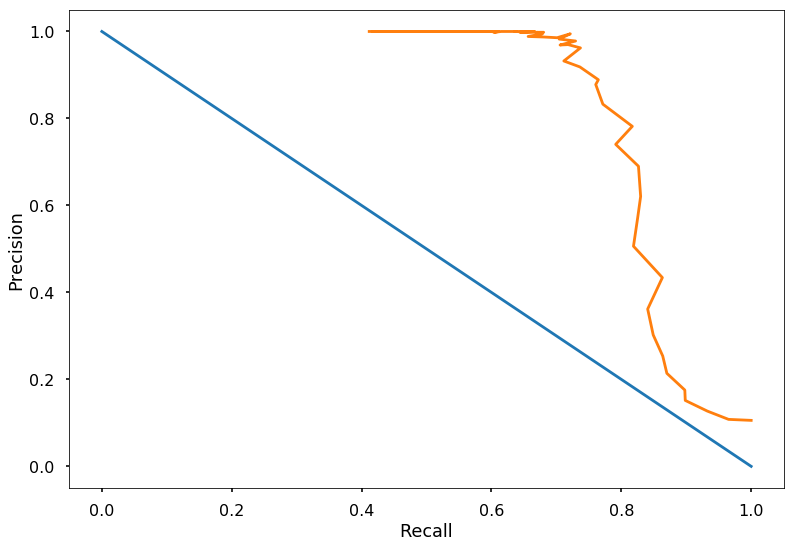

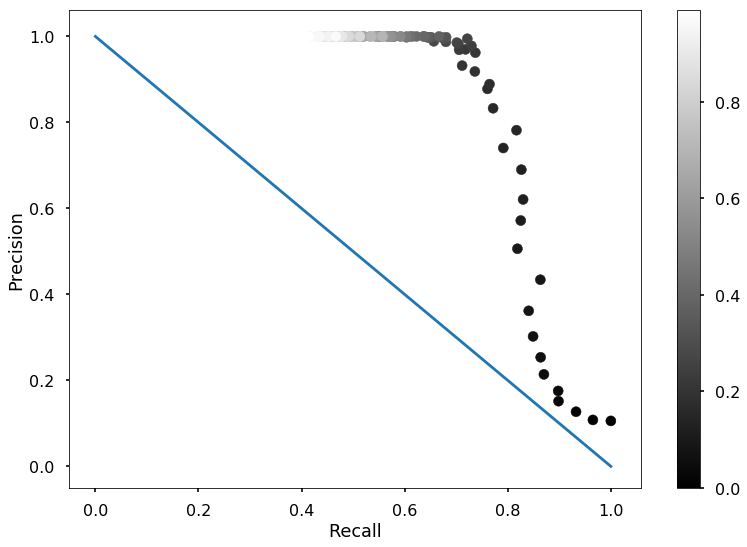

In [105]:
plt.plot(np.linspace(0, 1, 100), np.linspace(1, 0, 100))
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(1, 0, 100))
plt.scatter(recall, precision, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

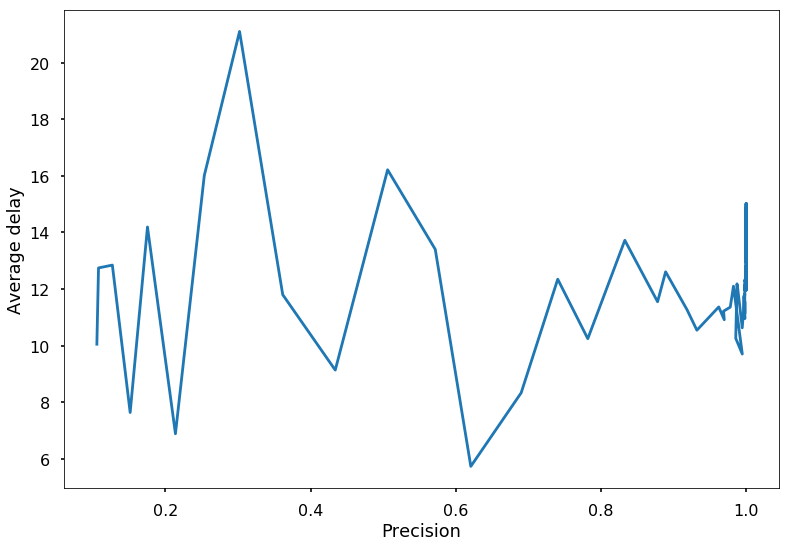

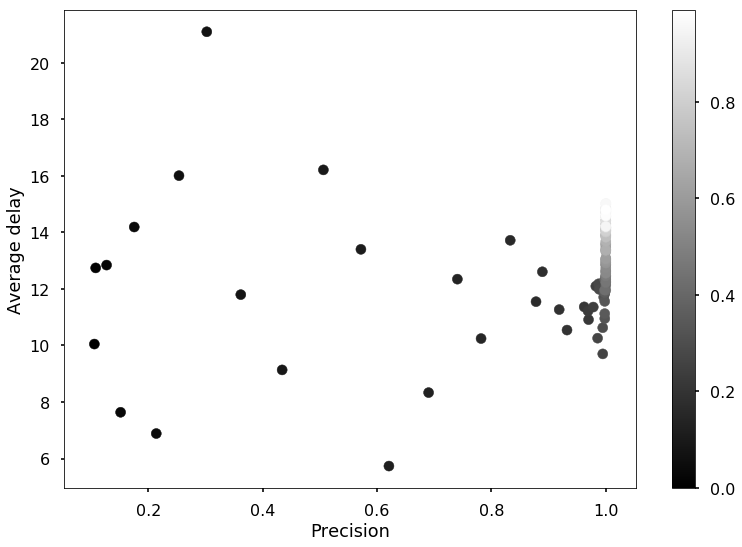

In [106]:
plt.plot([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay)
plt.ylabel('Average delay')
plt.xlabel('Precision')
plt.show()

plt.scatter([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Average delay')
plt.xlabel('Precision')
plt.show()

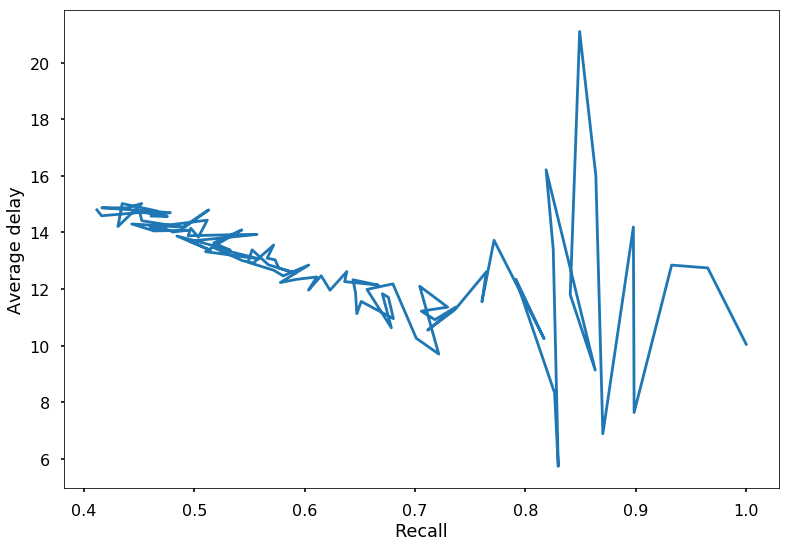

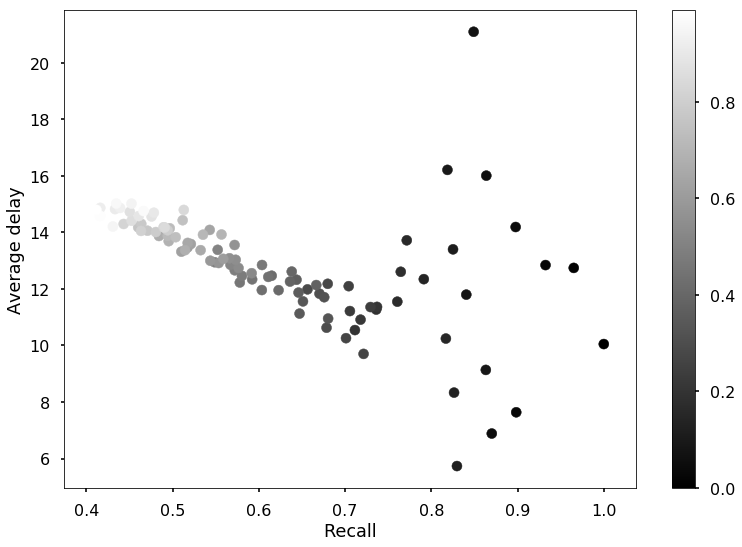

In [107]:
plt.plot([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay)
plt.ylabel('Average delay')
plt.xlabel('Recall')
plt.show()

plt.scatter([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Average delay')
plt.xlabel('Recall')
plt.show()

### Попробуем prediction based подход

In [53]:
def prediction_mean(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[half_window:window] - np.mean(time_series[0:half_window]))**2)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    result.extend(list(right_ts_cost)/norm)
    
#     for i in range(len(time_series) - window + 1):
#         left_ts = time_series[i:int(i+window/2)]
#         right_ts = time_series[int(i+window/2):i+window]
#         left_ts_cost = sum((right_ts - np.mean(left_ts))**2)/norm
#         result.append(left_ts_cost)

    return(result)

In [54]:
def cp_detection_modeling_2(iterations = 1000, max_delay = 49, _window = 48, _cp_prob = 0.8, _is_multiplicative = True, _threshold = 0.15):
    act, pred = [], []
    for i in range(iterations):
        act_temp, pred_temp = [], []
        generated = data_generator(cp_prob = _cp_prob, is_multiplicative = _is_multiplicative)
        generated_part = generated[0]
        breaker, counter = True, 0
        while breaker:
            if counter == 0:
                cp_1 = prediction_mean(generated[0], _window)
                cp_2 = cp_detection(cp_1, _threshold)
                pred_temp.append(cp_2)
                act_temp.append(generated[1])
                if cp_2 == None:
                    breaker = False
                else:
                    generated_part = generated[0][(cp_2+1):]
                    cumulative_cp_2 = cp_2
                counter += 1
            else:
                cp_1 = prediction_mean(generated_part, _window)
                cp_2 = cp_detection(cp_1, _threshold)
                if cp_2 == None:
                    breaker = False
                else:            
                    cumulative_cp_2 += cp_2
                    cp_2 = cumulative_cp_2 + 1
                    pred_temp.append(cp_2)
                    act_temp.append(generated[1])
                    generated_part = generated[0][(cp_2+1):]
                counter += 1

            if len(generated_part) < _window:
                breaker = False
                
        change_point_found = len([x for x in pred_temp if 
                                  (x != None and 
                                  generated[1] != None and 
                                  x <= generated[1]+max_delay and 
                                  x >= generated[1]) or 
                                  x == None or 
                                  generated[1] == None]) # it's better to move this part into cp_quality function
        if change_point_found == 0: # to count cases w/o detection
            pred_temp.append(None)
            act_temp.append(generated[1])
        act.extend(act_temp)
        pred.extend(pred_temp)
    return([act, pred])

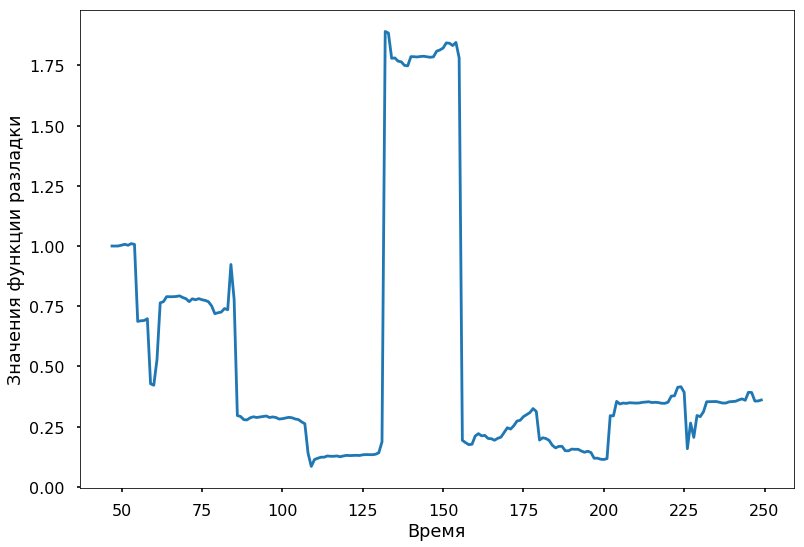

In [73]:
plt.plot(prediction_mean(generated[0][150:], window=48))
plt.ylabel('Значения функции разладки')
plt.xlabel('Время')
# plt.savefig('./fig/prediction_mean_1.png')
plt.show()

In [78]:
%%time
threshold_list = [x/25 for x in range(100)]
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []

for tr in threshold_list:
    actual_temp, predicted_temp = cp_detection_modeling_2(iterations = 100, 
                                              _window = 48,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              _threshold = tr)
    actual.extend(actual_temp)
    predicted.extend(predicted_temp)
    thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

Wall time: 15.8 s


In [85]:
df_cp.shape

(32213, 3)

In [80]:
temp = cp_quality(df_cp.loc[df_cp['threshold'] == 0.8, 'actual'], 
                     df_cp.loc[df_cp['threshold'] == 0.8, 'predicted']
                          )[0]

print(temp)
print('Recall: {} \n FPR: {}'.format(temp[1,1]/sum(temp[1,:]),temp[0,1]/sum(temp[0,:]) ))

[[  0 720]
 [  0  80]]
Recall: 1.0 
 FPR: 1.0


In [82]:
precision_pr_based = []
recall_pr_based = []
specificity_pr_based = []
average_delay_pr_based = []
precision_filter_pr_based = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision_pr_based.append(1)
    else:
        precision_pr_based.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
        
    if sum(cp_result[0][1,:]) == 0:
        recall_pr_based.append(1)
    else:
        recall_pr_based.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
        
    if sum(cp_result[0][0,:]) == 0:
        specificity_pr_based.append(1)
    else:
        specificity_pr_based.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    
    
    if cp_result[1]:
        average_delay_pr_based.append(np.mean(cp_result[1]))
        precision_filter_pr_based.append(True)
    else:
        precision_filter_pr_based.append(False)
    
#     test.append(cp_result[0])

unspecificity_pr_based = [1-x for x in specificity_pr_based]

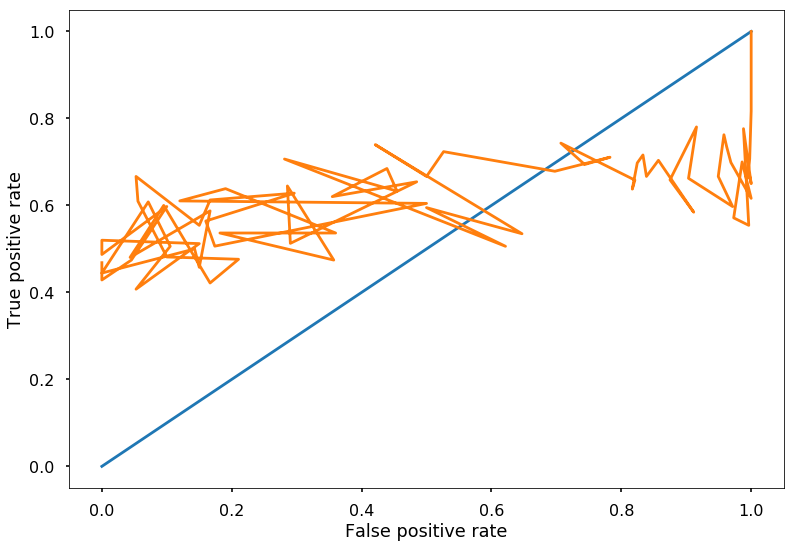

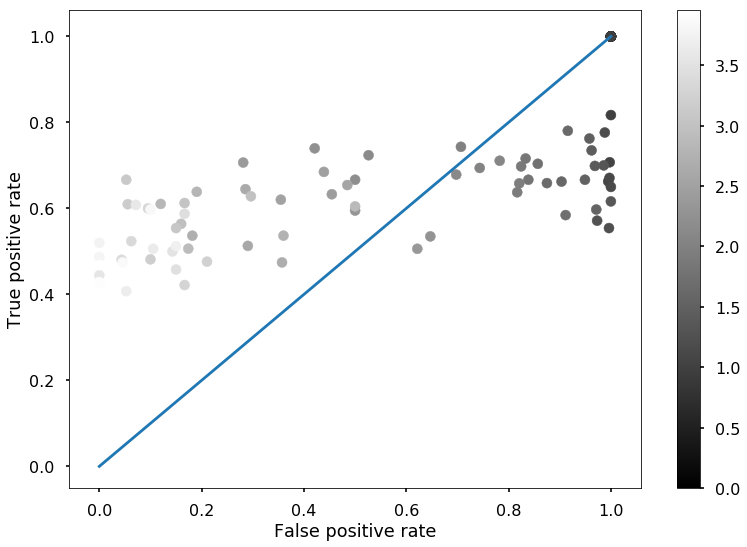

In [83]:
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity_pr_based, recall_pr_based)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
# plt.savefig('./fig/prediction_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity_pr_based, recall_pr_based, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

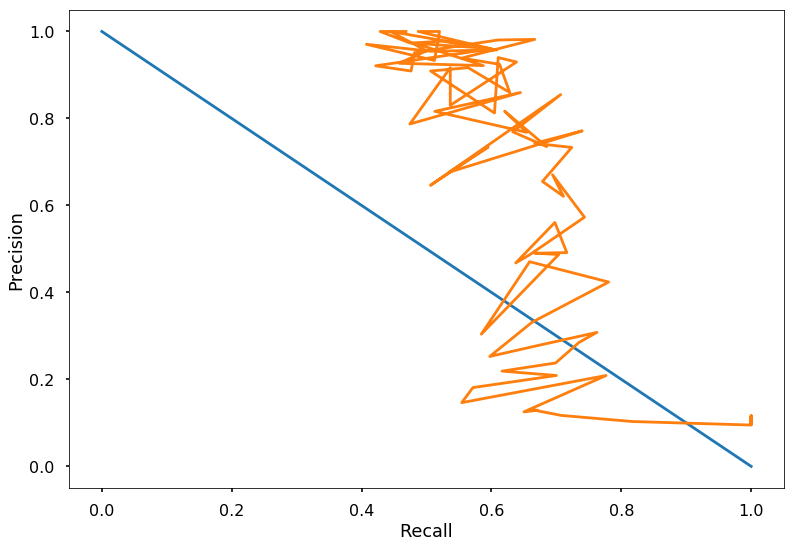

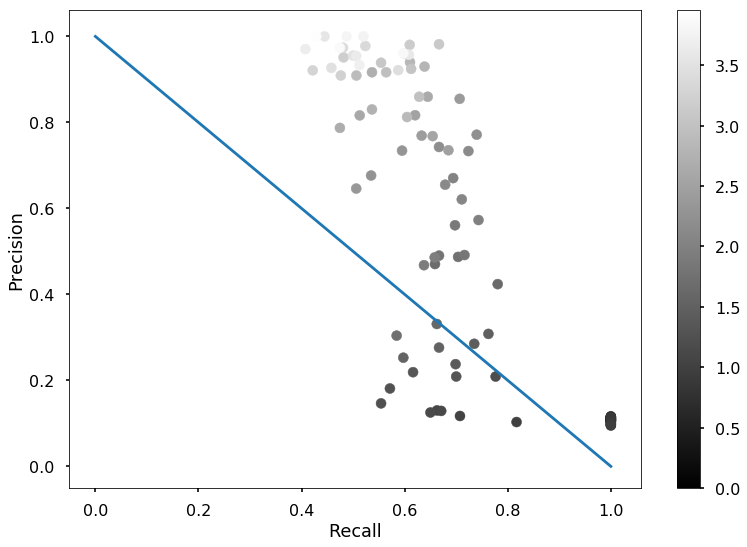

In [84]:
plt.plot(np.linspace(0, 1, 100), np.linspace(1, 0, 100))
plt.plot(recall_pr_based, precision_pr_based)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(1, 0, 100))
plt.scatter(recall_pr_based, precision_pr_based, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Проблема: непонятно какие значения порога выбирать для отрисовки ROC кривой и пр.

Идея: 
- генерируем $N$ рядов, по каждому из них считаем значение разладки
- считаем 95 квантиль (либо максимум) значения разладки $T$
- выбираем 100 порогов от нуля до $T$ с равномерным шагом

In [87]:
detection_values = []
for i in range(1000):    
    generated = data_generator(cp_prob = 0.8, is_multiplicative = False)
    cp_1 = approximation_mean(generated[0], 48)
    detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
# threshold_max = max(detection_values)
# print('Threshold maximum is {}'.format(threshold_max))

threshold_max = np.percentile(detection_values, 95)
print('Threshold 95 percentile is {}'.format(threshold_max))

threshold_max = int(round(threshold_max,0))
print(threshold_max)

Threshold 95 percentile is 20.16986371807076
20


In [88]:
%%time
threshold_list = list(np.arange(0, threshold_max, threshold_max/100))
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []

for tr in threshold_list:
    actual_temp, predicted_temp = cp_detection_modeling(iterations = 1000, 
                                              _window = 48,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              _threshold = tr)
    actual.extend(actual_temp)
    predicted.extend(predicted_temp)
    thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

Wall time: 1min 52s


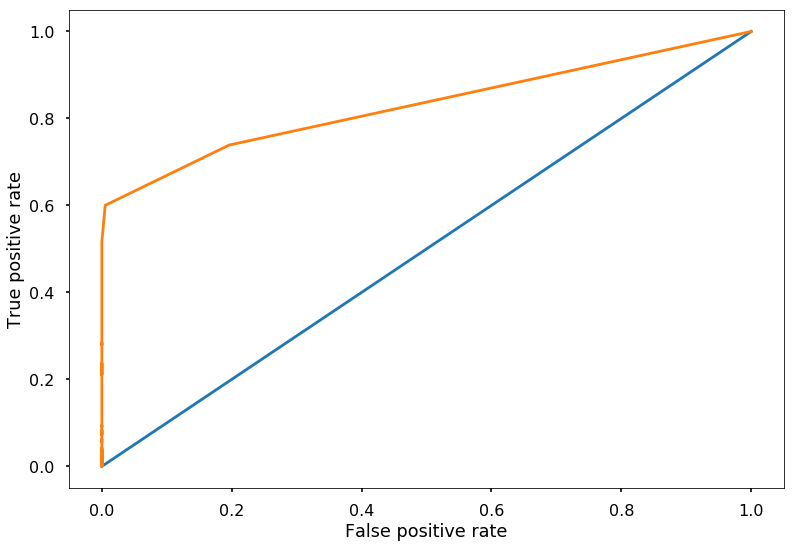

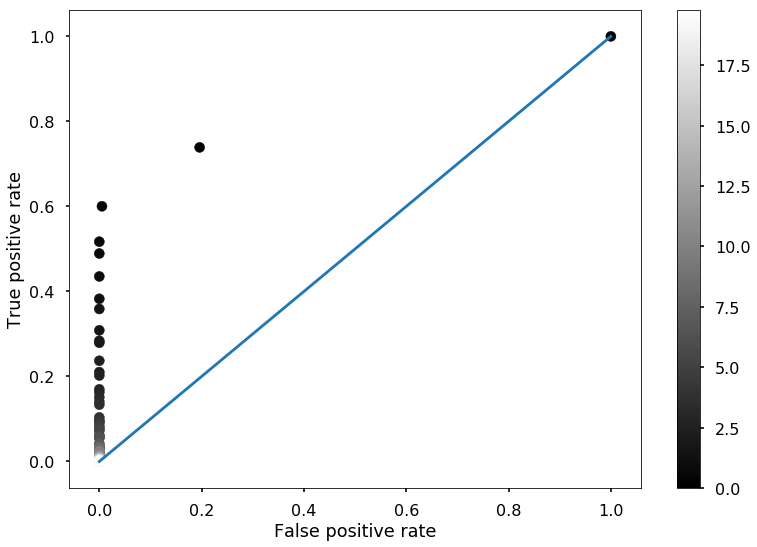

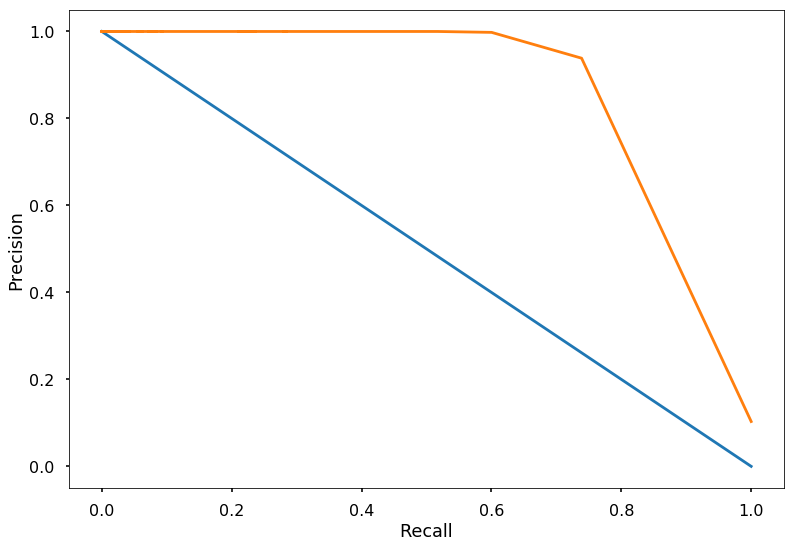

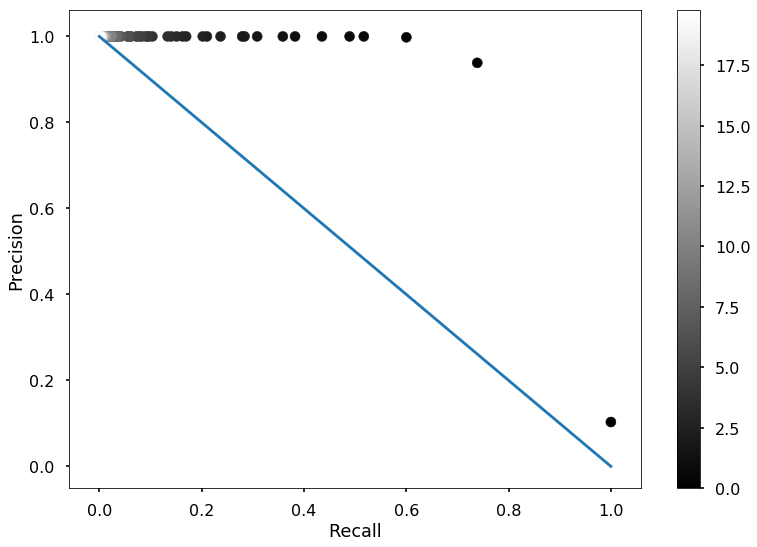

In [89]:
precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
        
    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
        
    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    
    
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])

unspecificity = [1-x for x in specificity]


plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity, recall)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(1, 0, 100))
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(1, 0, 100))
plt.scatter(recall, precision, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [92]:
detection_values = []
for i in range(1000):    
    generated = data_generator(cp_prob = 0.8, is_multiplicative = False)
    cp_1 = prediction_mean(generated[0], 48)
    detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
# threshold_max = max(detection_values)
# print('Threshold maximum is {}'.format(threshold_max))

threshold_max = np.percentile(detection_values, 95)
print('Threshold 95 percentile is {}'.format(threshold_max))

threshold_max = int(round(threshold_max,0))
print(threshold_max)

Threshold 95 percentile is 1270.918533047645
1271


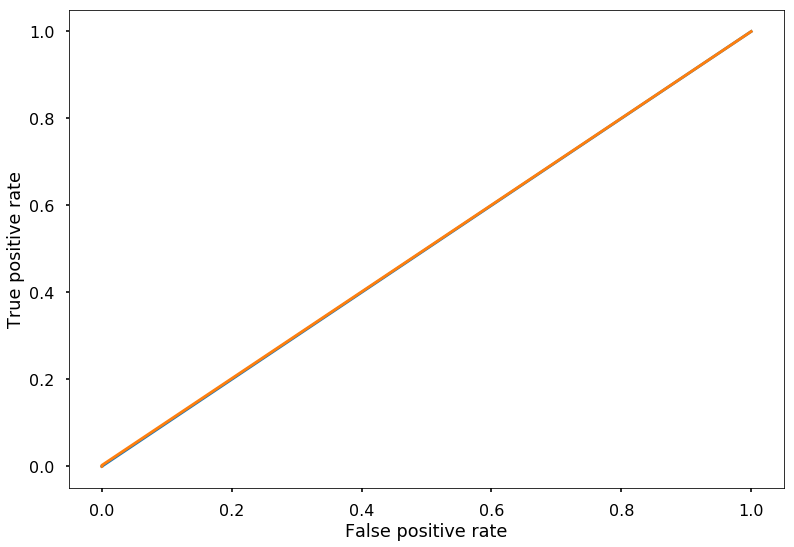

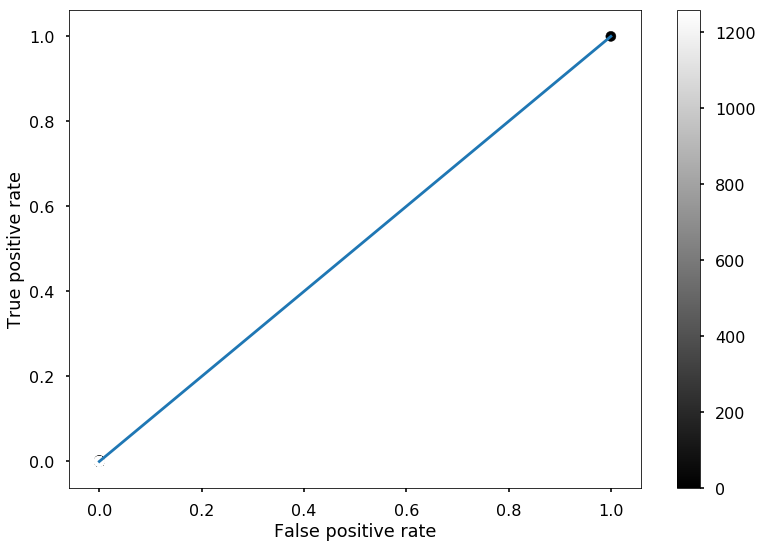

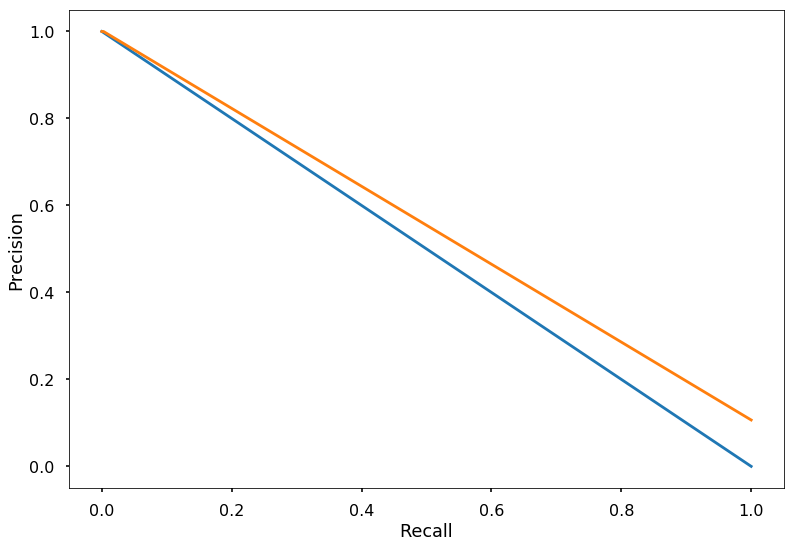

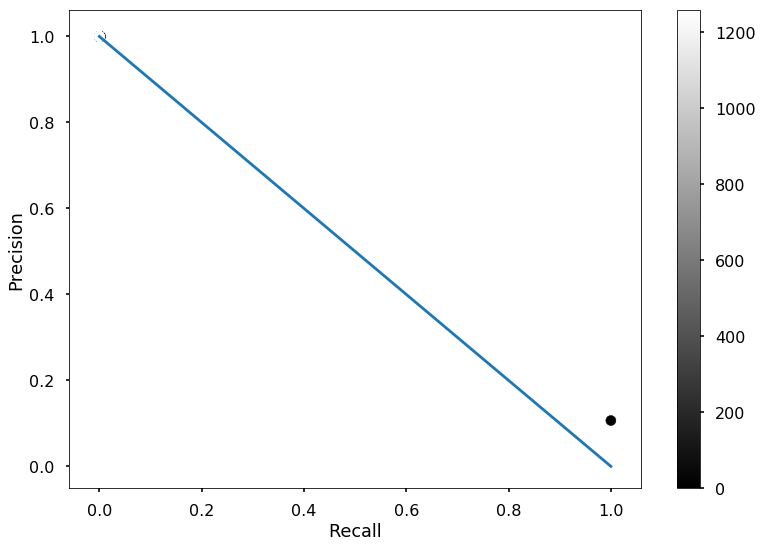

Wall time: 1min 39s


In [93]:
%%time
threshold_list = list(np.arange(0, threshold_max, threshold_max/100))
# threshold_list = [x/1000 for x in range(1000)]
actual, predicted, thresholds = [], [], []

for tr in threshold_list:
    actual_temp, predicted_temp = cp_detection_modeling(iterations = 1000, 
                                              _window = 48,
                                              _cp_prob = 0.8,
                                              _is_multiplicative = False,
                                              _threshold = tr)
    actual.extend(actual_temp)
    predicted.extend(predicted_temp)
    thresholds.extend([tr]*len(actual_temp))

df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})


precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    if sum(cp_result[0][:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
        
    if sum(cp_result[0][1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
        
    if sum(cp_result[0][0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))    
    
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])

unspecificity = [1-x for x in specificity]


plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(unspecificity, recall)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(1, 0, 100))
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(1, 0, 100))
plt.scatter(recall, precision, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Попробуем без мультипликативности

In [90]:
# detection_values = []
# for i in range(1000):    
#     generated = data_generator(cp_prob = 0.8, is_multiplicative = False)
#     cp_1 = approximation_mean(generated[0], 48)
#     detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
# # threshold_max = max(detection_values)
# # print('Threshold maximum is {}'.format(threshold_max))

# threshold_max = np.percentile(detection_values, 95)
# print('Threshold 95 percentile is {}'.format(threshold_max))

# # threshold_max = int(round(threshold_max,0))
# # print(threshold_max)


# df_cp = pd.DataFrame({'actual': None, 'predicted': None, 'threshold': None}, index = [])
# threshold_list = list(np.arange(0, threshold_max, threshold_max/100))
# act_temp, pred_temp, tr_temp = [], [], []
# for i in range(1000):    
#     generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
#     cp_1 = approximation_mean(generated[0], 48)
#     for tr in threshold_list:
#         cp_2 = cp_detection(cp_1, tr)
#         act_temp.append(generated[1])
#         pred_temp.append(cp_2)
#         tr_temp.append(tr)
# #         df_cp = df_cp.append({'actual': generated[1], 'predicted': cp_2, 'threshold': tr}, ignore_index=True)

# df_cp = pd.DataFrame({'actual': act_temp, 'predicted': pred_temp, 'threshold': tr_temp})

# precision = []
# recall = []
# specificity = []
# average_delay = []
# precision_filter = []
# # test = []

# for tr in threshold_list:
#     cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
#                            df_cp.loc[df_cp['threshold'] == tr, 'predicted']
#                           )
    
#     precision.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
#     recall.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
#     specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))
#     if cp_result[1]:
#         average_delay.append(np.mean(cp_result[1]))
#         precision_filter.append(True)
#     else:
#         precision_filter.append(False)
    
# #     test.append(cp_result[0])
    
# unspecificity = [1-x for x in specificity]

In [91]:
# plt.plot(unspecificity, precision)
# plt.ylabel('True positive rate')
# plt.xlabel('False positive rate')
# plt.show()

# plt.scatter(unspecificity, precision, c=threshold_list, s=100, cmap='gray')
# plt.colorbar()
# plt.ylabel('True positive rate')
# plt.xlabel('False positive rate')
# plt.show()


# plt.plot(recall, precision)
# plt.ylabel('Precision')
# plt.xlabel('Recall')
# plt.show()

# plt.scatter(recall, precision, c=threshold_list, s=100, cmap='gray')
# plt.colorbar()
# plt.ylabel('Precision')
# plt.xlabel('Recall')
# plt.show()

# plt.plot([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay)
# plt.ylabel('Average delay')
# plt.xlabel('Precision')
# plt.show()

# plt.scatter([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
# plt.colorbar()
# plt.ylabel('Average delay')
# plt.xlabel('Precision')
# plt.show()

# plt.plot([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay)
# plt.ylabel('Average delay')
# plt.xlabel('Recall')
# plt.show()

# plt.scatter([recall[i] for i in range(len(recall)) if precision_filter[i]], average_delay, c=[threshold_list[i] for i in range(len(threshold_list)) if precision_filter[i]], s=100, cmap='gray')
# plt.colorbar()
# plt.ylabel('Average delay')
# plt.xlabel('Recall')
# plt.show()

